In [1]:
from qiskit import QuantumCircuit
from qiskit.dagcircuit import DAGCircuit
from qiskit.converters import circuit_to_dag, dag_to_circuit
from qiskit.transpiler import PassManager
from qiskit.transpiler import CouplingMap
from qiskit.transpiler.passes import SabreLayout
from pytket.utils import compare_unitaries
import canopus

In [2]:
qc = QuantumCircuit(6)
qc.h(0)
qc.h(2)
qc.h(5)
qc.z(0)
qc.cx(1, 2)
qc.cx(4, 5)
qc.cx(0, 1)
qc.cx(2, 3)
qc.h(2)
qc.h(3)
qc.cx(1, 2)
qc.cx(3, 5)
qc.z(3)
qc.cx(3, 4)
qc.cx(0, 3)

dag = circuit_to_dag(qc)
qc.draw()

┌───┐┌───┐                              
q_0: ┤ H ├┤ Z ├──■────────────────────────■──
     └───┘└───┘┌─┴─┐                      │  
q_1: ───────■──┤ X ├───────■──────────────┼──
     ┌───┐┌─┴─┐└───┘┌───┐┌─┴─┐            │  
q_2: ┤ H ├┤ X ├──■──┤ H ├┤ X ├────────────┼──
     └───┘└───┘┌─┴─┐├───┤└───┘┌───┐     ┌─┴─┐
q_3: ──────────┤ X ├┤ H ├──■──┤ Z ├──■──┤ X ├
               └───┘└───┘  │  └───┘┌─┴─┐└───┘
q_4: ───────■──────────────┼───────┤ X ├─────
     ┌───┐┌─┴─┐          ┌─┴─┐     └───┘     
q_5: ┤ H ├┤ X ├──────────┤ X ├───────────────
     └───┘└───┘          └───┘

In [5]:
coupling_map = CouplingMap.from_line(qc.num_qubits)
# coupling_map = CouplingMap.from_grid(3, 3)

from qiskit import transpile

canopus_backend = canopus.CanopusBackend(canopus.ISAType.Canonical, canopus.CouplingType.XY, coupling_map=coupling_map)

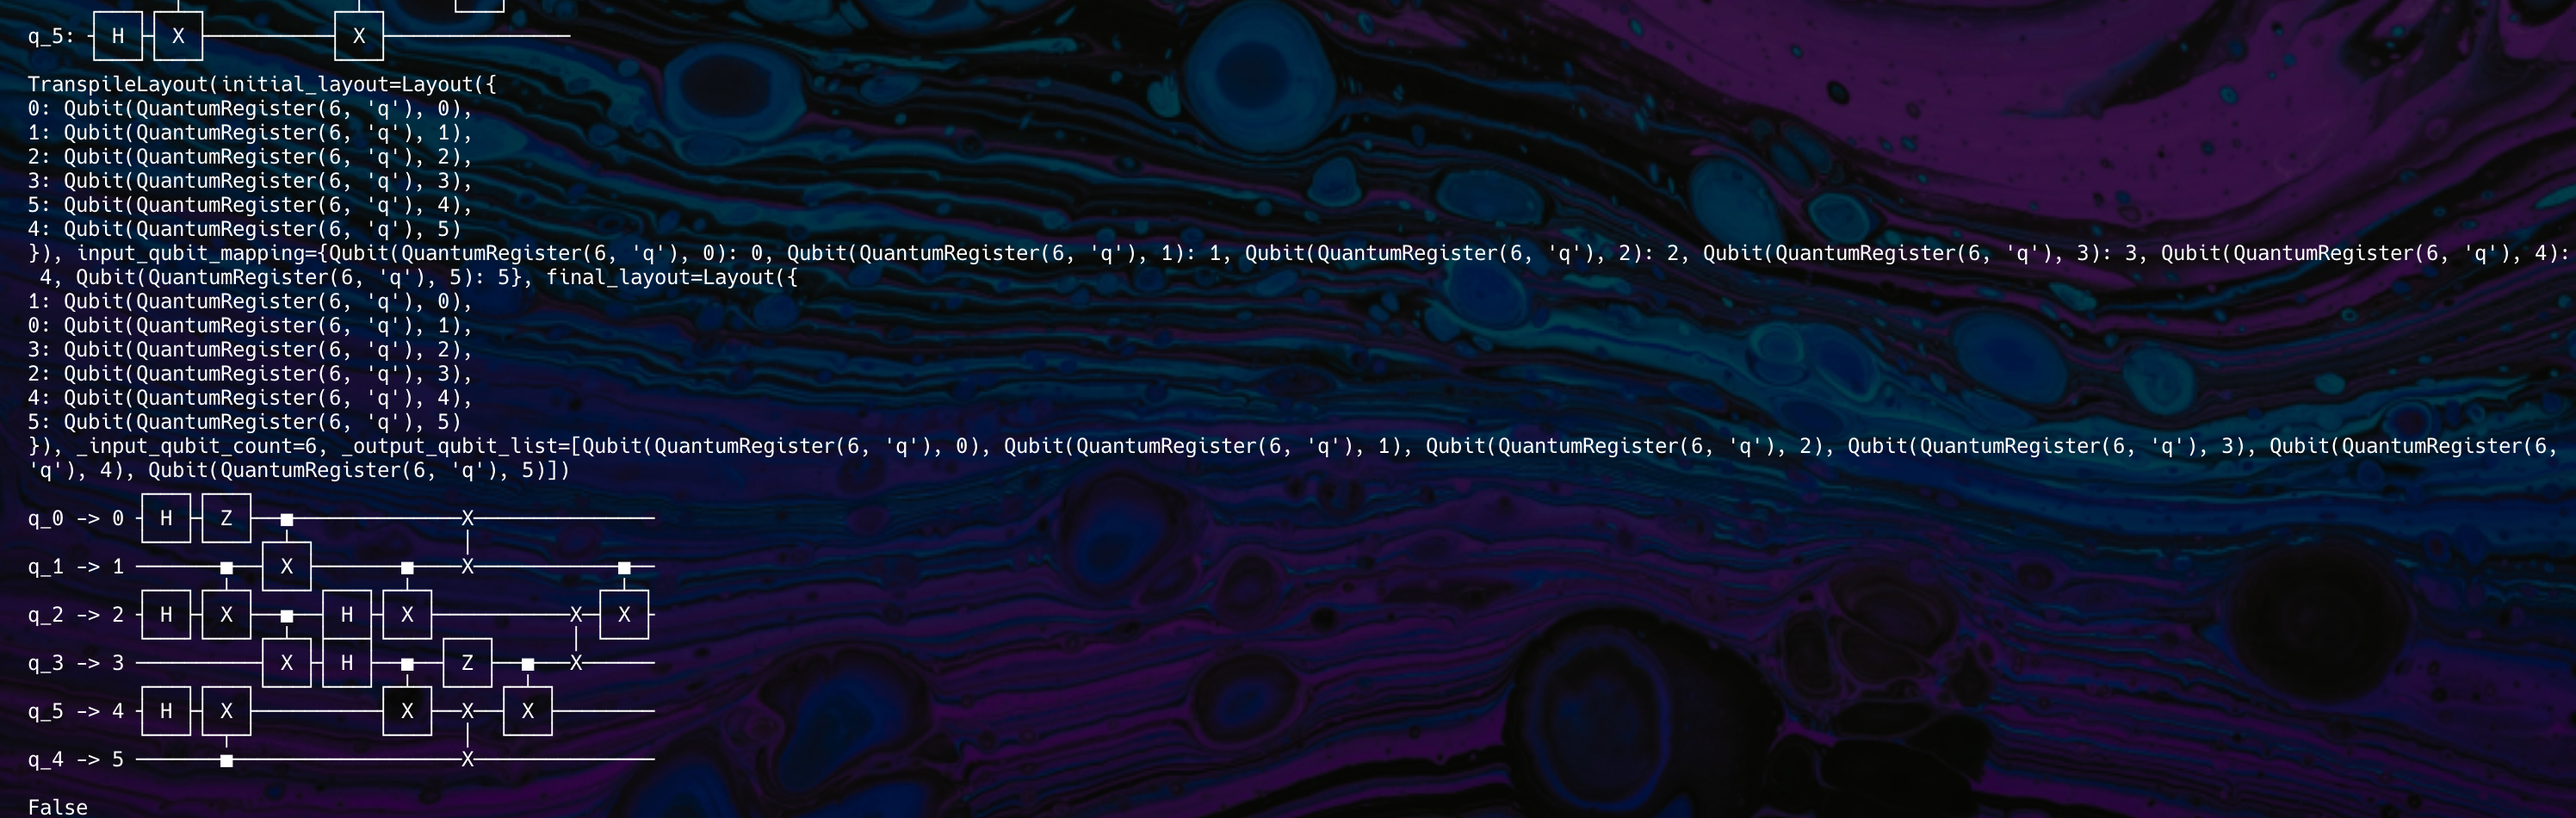

In [23]:
pm = PassManager([
    SabreLayout(coupling_map=coupling_map)
])
qc1 = pm.run(qc)
# qc1 = transpile(qc, coupling_map=coupling_map, optimization_level=1)
qc1.draw()

┌───┐┌───┐                                 
q_0 -> 0 ┤ H ├┤ Z ├──■──────────────X───────────────
         └───┘└───┘┌─┴─┐            │               
q_1 -> 1 ───────■──┤ X ├───────■────X────────────■──
         ┌───┐┌─┴─┐└───┘┌───┐┌─┴─┐             ┌─┴─┐
q_2 -> 2 ┤ H ├┤ X ├──■──┤ H ├┤ X ├───────────X─┤ X ├
         └───┘└───┘┌─┴─┐├───┤└───┘┌───┐      │ └───┘
q_3 -> 3 ──────────┤ X ├┤ H ├──■──┤ Z ├──■───X──────
         ┌───┐┌───┐└───┘└───┘┌─┴─┐└───┘┌─┴─┐        
q_5 -> 4 ┤ H ├┤ X ├──────────┤ X ├──X──┤ X ├────────
         └───┘└─┬─┘          └───┘  │  └───┘        
q_4 -> 5 ───────■───────────────────X───────────────

In [38]:
qc1.layout

TranspileLayout(initial_layout=Layout({
0: Qubit(QuantumRegister(6, 'q'), 0),
1: Qubit(QuantumRegister(6, 'q'), 1),
2: Qubit(QuantumRegister(6, 'q'), 2),
3: Qubit(QuantumRegister(6, 'q'), 3),
5: Qubit(QuantumRegister(6, 'q'), 4),
4: Qubit(QuantumRegister(6, 'q'), 5)
}), input_qubit_mapping={Qubit(QuantumRegister(6, 'q'), 0): 0, Qubit(QuantumRegister(6, 'q'), 1): 1, Qubit(QuantumRegister(6, 'q'), 2): 2, Qubit(QuantumRegister(6, 'q'), 3): 3, Qubit(QuantumRegister(6, 'q'), 4): 4, Qubit(QuantumRegister(6, 'q'), 5): 5}, final_layout=Layout({
1: Qubit(QuantumRegister(6, 'q'), 0),
0: Qubit(QuantumRegister(6, 'q'), 1),
3: Qubit(QuantumRegister(6, 'q'), 2),
2: Qubit(QuantumRegister(6, 'q'), 3),
5: Qubit(QuantumRegister(6, 'q'), 4),
4: Qubit(QuantumRegister(6, 'q'), 5)
}), _input_qubit_count=6, _output_qubit_list=[Qubit(QuantumRegister(6, 'q'), 0), Qubit(QuantumRegister(6, 'q'), 1), Qubit(QuantumRegister(6, 'q'), 2), Qubit(QuantumRegister(6, 'q'), 3), Qubit(QuantumRegister(6, 'q'), 4), Qubit(Qua

In [31]:
qc1.layout.final_index_layout()

[1, 0, 3, 2, 4, 5]

In [33]:
qc1.layout.initial_index_layout()

[0, 1, 2, 3, 5, 4]

In [30]:
from qiskit.quantum_info import Operator
Operator.from_circuit(qc1).equiv(qc)

True

In [29]:
from qiskit import qasm2

In [31]:
print(qasm2.dumps(qc1))

OPENQASM 2.0;
include "qelib1.inc";
qreg q[9];
h q[2];
cx q[1],q[2];
u2(-pi,-pi) q[4];
cx q[4],q[1];
cx q[2],q[5];
h q[2];
cx q[1],q[2];
h q[5];
h q[8];
cx q[7],q[8];
cx q[5],q[8];
z q[5];
swap q[7],q[8];
cx q[5],q[8];
cx q[4],q[5];


In [6]:
# def verify_mapped_circuit(circ: Circuit, mapped_circ: Circuit, init_mapping: Dict[int, int],
#                           final_mapping: Dict[int, int]) -> bool:
#     """
#     Verify the correctness of the mapped circuit with respect to the original circuit.
#     Fist append necessary SWAP gates on the mapped circuit.
#     Then compare the unitary matrices of the two circuits.

#     Args:
#         circ: original circuit, whose qregs indices are logical qubits
#         mapped_circ: mapped circuit, whose qregs indices are logical qubits
#         init_mapping: initial mapping from logical to physical qubits
#         final_mapping: final mapping from logical to physical qubits

#     Returns:
#         True if the mapped circuit is correct. False otherwise.
#     """
#     init_final_mapping = obtain_logic_logic_mapping(init_mapping, final_mapping)
#     mat1 = circ.unitary()
#     mapped_circ = mapped_circ.deepclone()
#     mapped_circ.append(*obtain_appended_swaps(init_final_mapping))
#     mat2 = mapped_circ.unitary()

#     from regulus.utils.ops import is_equiv_unitary
#     return is_equiv_unitary(mat1, mat2)

In [7]:
pm = PassManager([
    canopus.SabreMapping(canopus_backend)
])
qc2 = pm.run(qc)
qc2.draw()

q_4 -> 0 ───────■───────────────────X────────────
         ┌───┐┌─┴─┐          ┌───┐  │  ┌───┐     
q_5 -> 1 ┤ H ├┤ X ├──────────┤ X ├──X──┤ X ├─────
         └───┘└───┘┌───┐┌───┐└─┬─┘┌───┐└─┬─┘┌───┐
q_3 -> 2 ──────────┤ X ├┤ H ├──■──┤ Z ├──■──┤ X ├
         ┌───┐┌───┐└─┬─┘├───┤┌───┐└───┘     └─┬─┘
q_2 -> 3 ┤ H ├┤ X ├──■──┤ H ├┤ X ├───────X────■──
         └───┘└─┬─┘┌───┐└───┘└─┬─┘       │       
q_1 -> 4 ───────■──┤ X ├───────■────X────X───────
         ┌───┐┌───┐└─┬─┘            │            
q_0 -> 5 ┤ H ├┤ Z ├──■──────────────X────────────
         └───┘└───┘

In [11]:
from qiskit.quantum_info import Operator

Operator.from_circuit(qc2)

Operator([[ 0.35355339+0.j,  0.35355339+0.j,  0.        +0.j, ...,
            0.        +0.j,  0.        +0.j,  0.        +0.j],
          [ 0.35355339+0.j,  0.35355339+0.j,  0.        +0.j, ...,
            0.        +0.j,  0.        +0.j,  0.        +0.j],
          [ 0.        +0.j,  0.        +0.j,  0.        +0.j, ...,
            0.        +0.j,  0.        +0.j,  0.        +0.j],
          ...,
          [-0.35355339+0.j,  0.35355339+0.j,  0.        +0.j, ...,
            0.        +0.j,  0.        +0.j,  0.        +0.j],
          [ 0.        +0.j,  0.        +0.j,  0.        +0.j, ...,
            0.        +0.j,  0.        +0.j,  0.        +0.j],
          [ 0.        +0.j,  0.        +0.j,  0.        +0.j, ...,
            0.        +0.j,  0.        +0.j,  0.        +0.j]],
         input_dims=(2, 2, 2, 2, 2, 2), output_dims=(2, 2, 2, 2, 2, 2))


In [16]:
qc1.layout


TranspileLayout(initial_layout=Layout({
5: Qubit(QuantumRegister(6, 'q'), 0),
4: Qubit(QuantumRegister(6, 'q'), 1),
3: Qubit(QuantumRegister(6, 'q'), 2),
2: Qubit(QuantumRegister(6, 'q'), 3),
0: Qubit(QuantumRegister(6, 'q'), 4),
1: Qubit(QuantumRegister(6, 'q'), 5)
}), input_qubit_mapping={Qubit(QuantumRegister(6, 'q'), 0): 0, Qubit(QuantumRegister(6, 'q'), 1): 1, Qubit(QuantumRegister(6, 'q'), 2): 2, Qubit(QuantumRegister(6, 'q'), 3): 3, Qubit(QuantumRegister(6, 'q'), 4): 4, Qubit(QuantumRegister(6, 'q'), 5): 5}, final_layout=Layout({
1: Qubit(QuantumRegister(6, 'q'), 0),
0: Qubit(QuantumRegister(6, 'q'), 1),
3: Qubit(QuantumRegister(6, 'q'), 2),
2: Qubit(QuantumRegister(6, 'q'), 3),
5: Qubit(QuantumRegister(6, 'q'), 4),
4: Qubit(QuantumRegister(6, 'q'), 5)
}), _input_qubit_count=6, _output_qubit_list=[Qubit(QuantumRegister(6, 'q'), 0), Qubit(QuantumRegister(6, 'q'), 1), Qubit(QuantumRegister(6, 'q'), 2), Qubit(QuantumRegister(6, 'q'), 3), Qubit(QuantumRegister(6, 'q'), 4), Qubit(Qua

In [ ]:
from qiskit.transpiler import Layout

In [14]:
qc2.layout

TranspileLayout(initial_layout=Layout({
5: Qubit(QuantumRegister(6, 'q'), 0),
4: Qubit(QuantumRegister(6, 'q'), 1),
2: Qubit(QuantumRegister(6, 'q'), 3),
3: Qubit(QuantumRegister(6, 'q'), 2),
1: Qubit(QuantumRegister(6, 'q'), 5),
0: Qubit(QuantumRegister(6, 'q'), 4)
}), input_qubit_mapping={Qubit(QuantumRegister(6, 'q'), 0): 0, Qubit(QuantumRegister(6, 'q'), 1): 1, Qubit(QuantumRegister(6, 'q'), 2): 2, Qubit(QuantumRegister(6, 'q'), 3): 3, Qubit(QuantumRegister(6, 'q'), 4): 4, Qubit(QuantumRegister(6, 'q'), 5): 5}, final_layout=Layout({
2: Qubit(QuantumRegister(6, 'q'), 3),
1: Qubit(QuantumRegister(6, 'q'), 4),
0: Qubit(QuantumRegister(6, 'q'), 5),
5: Qubit(QuantumRegister(6, 'q'), 1),
3: Qubit(QuantumRegister(6, 'q'), 0),
4: Qubit(QuantumRegister(6, 'q'), 2)
}), _input_qubit_count=6, _output_qubit_list=[Qubit(QuantumRegister(6, 'q'), 0), Qubit(QuantumRegister(6, 'q'), 1), Qubit(QuantumRegister(6, 'q'), 2), Qubit(QuantumRegister(6, 'q'), 3), Qubit(QuantumRegister(6, 'q'), 4), Qubit(Qua

In [12]:
Operator.from_circuit(qc2).equiv(qc)

False

In [17]:
from qiskit.utils.parallel import CPU_COUNT

In [18]:
CPU_COUNT

7

In [15]:
PARALLEL_DEFAULT

False

In [6]:
from qiskit.transpiler import CouplingMap

In [11]:
CouplingMap.from_grid(2, 4).is_symmetric

True

In [22]:
dir(dag)

['__class__',
 '__delattr__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '_apply_op_node_back',
 '_calibrations_prop',
 '_check_condition',
 '_duration',
 '_edges',
 '_find_successors_by_edge',
 '_has_calibration_for',
 '_has_edge',
 '_in_edges',
 '_in_wires',
 '_is_dag',
 '_out_edges',
 '_out_wires',
 '_to_dot',
 '_unit',
 'add_calibration',
 'add_captured_var',
 'add_clbits',
 'add_creg',
 'add_declared_var',
 'add_input_var',
 'add_qreg',
 'add_qubits',
 'ancestors',
 'apply_operation_back',
 'apply_operation_front',
 'bfs_successors',
 'calibrations',
 'classical_predecessors',
 'classical_successors',
 'clbits',
 'collect_1q_runs',
 'collect_2q_runs',
 'collect_runs',
 'compose',
 'c

In [21]:


dir(list(dag.layers())[0]['graph'])

['__class__',
 '__delattr__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '_apply_op_node_back',
 '_calibrations_prop',
 '_check_condition',
 '_duration',
 '_edges',
 '_find_successors_by_edge',
 '_has_calibration_for',
 '_has_edge',
 '_in_edges',
 '_in_wires',
 '_is_dag',
 '_out_edges',
 '_out_wires',
 '_to_dot',
 '_unit',
 'add_calibration',
 'add_captured_var',
 'add_clbits',
 'add_creg',
 'add_declared_var',
 'add_input_var',
 'add_qreg',
 'add_qubits',
 'ancestors',
 'apply_operation_back',
 'apply_operation_front',
 'bfs_successors',
 'calibrations',
 'classical_predecessors',
 'classical_successors',
 'clbits',
 'collect_1q_runs',
 'collect_2q_runs',
 'collect_runs',
 'compose',
 'c

In [ ]:

# list(dag.serial_layers())

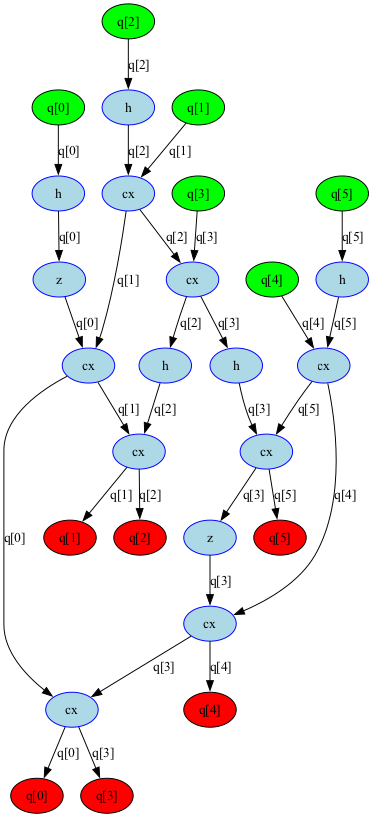

In [5]:
dag.draw()